simaliar to the first attempt but with cleaner code, more flexible layer creation

In [29]:
import numpy as np
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt

print("start!")

@dataclass
class Config:
    input_layer_size: int
    output_layer_size: int
    hidden_layer_num : int
    hidden_layer_size : int

    dataset_size : int
    learning_rate :float
    batch_size : int
    epochs : int



start!


In [30]:
def create_layer(layer_size, dtype=np.float32, **kwargs):
    layer = np.zeros(layer_size, dtype=dtype)
    return(layer)

def create_layer_weights(prev_ly_size, curr_ly_size, init=True):
    if init:
        #ly_weights = np.random.rand(prev_ly_size, curr_ly_size)
        ly_weights = np.random.uniform(-1,1, size=(prev_ly_size, curr_ly_size))
    else:
        ly_weights = np.zeros(shape=(prev_ly_size, curr_ly_size))
    return(ly_weights)

def create_biases(ly_size, init=True):
    if init:
        biases = np.random.rand(ly_size)
    else:
        biases = np.zeros(ly_size)
    return(biases)


def label_to_output(int) -> np.ndarray:
    outlayer = np.zeros(shape=(10), dtype=np.float32)
    outlayer[int] = 1
    return(outlayer)

def label_vec_to_output(inputs: np.ndarray) -> np.ndarray:
    # Create an identity matrix of size 10 and index into it
    return np.eye(10, dtype=np.int8)[inputs]

class n_network:
    def __init__(self, layers, z_layers, biases, weights):
        self.layers = layers
        self.z_layers = z_layers
        self.biases = biases
        self.weights = weights

def create_network(in_ly_size, out_ly_size, hidden_ly_num, hidden_ly_size):
    in_layer = create_layer(in_ly_size)
    hidden_lys = []
    for index in range(hidden_ly_num):
        hidden_lys.append(create_layer(hidden_ly_size))
    out_layer = create_layer(out_ly_size)
    network_lys = [in_layer, *hidden_lys, out_layer]
    
    z_layers = deep_copy_mat_list(network_lys, False)

    biases =[]
    for i in range(1, len(network_lys), 1):
        biases.append(create_biases(np.size(network_lys[i]), init=False))

    weights = []
    for i in range(1, len(network_lys), 1):
        weights.append( create_layer_weights(np.size(network_lys[i-1]), np.size(network_lys[i]), init=True))

    network = n_network(network_lys, z_layers, biases, weights)
    return(network)


def sigx(number):
    #sigmond function
    try:
        sig_x = ( 1 / (1+ math.exp(-number)))
        #this does not work for large negitive numbers 
        # due to rounding errors leading to devide by zero so we'll add error handling
    except OverflowError:
        sig_x = 0
    return(sig_x)

def sigmond(input):
    #a more easily vectorizable sigmond function
    return( 1/(1+np.exp(-input)))

def sigmond_prime(input):
    return(sigmond(input) * (1-sigmond(input)))

def forward(input_vals:np.ndarray, net:n_network):
    #first layer
    input_vals = np.array(input_vals)
    net.layers[0] = input_vals

    for index in range(1, len(net.layers), 1):
        net.z_layers[index] = np.dot(net.layers[(index-1)], net.weights[index-1]) + net.biases[index-1]
        net.layers[index] = sigmond(net.z_layers[index])  #activation function
    return(net)

def node_delta(expected:np.array, actual:np.array):
    delta = expected - actual
    return(delta)

def deep_copy_mat_list (list_to_copy, propigate_cell_vals=True):
    #creates a copy of a list containing numpy arrays of varible size, ethier as empty arrays or with the same values
    
    new_list = []
    if propigate_cell_vals:
        for items in list_to_copy:
            new_list.append(items)
    else:
        for items in list_to_copy:
            new_list.append(np.zeros_like(items))       

    return(new_list)


def loss(network_output_ly, expected_ly):
    #loss =  mean of all output neurons - the expected, squared
    loss_vec = ((network_output_ly - expected_ly)**2) / 2
    loss_sclr = np.sum((network_output_ly - expected_ly)**2)
    return(loss_sclr, loss_vec)

def backprop_single(net: n_network, expected_out_ly):
    #does backprop for a single training example, duhh
    first = True
    expected_out_ly = np.array(expected_out_ly)
    w_delta = deep_copy_mat_list(net.weights, propigate_cell_vals=False)
    b_delta = deep_copy_mat_list(net.biases, propigate_cell_vals=False)
    a_error = deep_copy_mat_list(net.layers, propigate_cell_vals=False)

    for l in range(len(net.layers)-1, 0, -1):
        w = l - 1

        if first:
            #first(last) layer
            first = False
            a_delta_dir = expected_out_ly - net.layers[l]
            a_error[l] = a_delta_dir * sigmond_prime(net.z_layers[l])

            a_error[l-1] = np.dot((net.weights[w]) , a_error[l]) * sigmond_prime(net.z_layers[l-1])
            w_delta[w] =  np.outer(net.layers[l-1], a_error[l])
            b_delta[w] = a_error[l]

        else:
            a_error[l] = np.dot((net.weights[w+1]) , a_error[l+1]) * sigmond_prime(net.z_layers[l])
            w_delta[w] =  np.outer(net.layers[l-1], a_error[l])
            b_delta[w] = a_error[l]

    return(w_delta, b_delta)

def create_batch(cfg:Config, batch_position, image_file, label_file):
   
    image_buffer = image_file.read(cfg.input_layer_size * cfg.batch_size)
    input_batch = np.frombuffer(image_buffer, dtype=np.uint8).astype(np.float32)
    input_batch = input_batch.reshape(cfg.batch_size, cfg.input_layer_size)
    
    label_buffer = label_file.read(cfg.batch_size)
    label_batch = np.frombuffer(label_buffer, dtype=np.uint8).astype(np.int64)
    Label_batch = label_vec_to_output(label_batch)

    return(input_batch, Label_batch)
    
def batch_learning(input_batch:np.ndarray, desired_output_batch:np.ndarray, net:n_network, cfg:Config):
    cfg.batch_size
    w_del_batch = []
    b_del_batch = []
    batch_loss = np.ndarray((cfg.batch_size,))

    for layers in net.weights:
        w_del_batch.append(np.zeros((cfg.batch_size,) + layers.shape, dtype=np.float32)  )
    for layers in net.biases:
        b_del_batch.append(np.zeros((cfg.batch_size,) + layers.shape, dtype=np.float32)  )


    for batch in range(cfg.batch_size):
        net = forward(input_batch[batch], net)
        w_del_batch_tmp, b_del_batch_tmp = backprop_single(net, desired_output_batch[batch])

        for layer_num in range(cfg.hidden_layer_num +1):   
            w_del_batch[layer_num][batch,:,:] = w_del_batch_tmp[layer_num]
            b_del_batch[layer_num][batch,:] = b_del_batch_tmp[layer_num]
        
        loss_sclr, loss_vec = loss(net.layers[-1], desired_output_batch[batch])
        batch_loss[batch] = loss_sclr
    batch_loss = np.mean(batch_loss)

    w_delta_mean = deep_copy_mat_list(net.weights, False)
    b_delta_mean = deep_copy_mat_list(net.biases, False)
    for layer_num in range(cfg.hidden_layer_num +1):   
        w_delta_mean[layer_num] = np.mean(w_del_batch[layer_num], axis=0) * cfg.learning_rate #learning rate is here!
        b_delta_mean[layer_num] = np.mean(b_del_batch[layer_num], axis=0) * cfg.learning_rate

    descent_step = w_delta_mean, b_delta_mean
    return(descent_step, batch_loss)

def train(images_pth, labels_pth, cfg:Config):
    x_data, y_data = [],[]
    from IPython.display import clear_output


    net = create_network(cfg.input_layer_size, cfg.output_layer_size, cfg.hidden_layer_num, cfg.hidden_layer_size)

    for epoch in range(cfg.epochs):
        print("epoch ", int(epoch), "out of ", int(cfg.epochs))
        f = open(images_pth, 'rb')
        f.read(16)
        l = open(labels_pth,'rb')
        l.read(8)
        for index in range(0, cfg.dataset_size, cfg.batch_size):
            #print("index position: ", int(index))
            input_ly, label_ly = create_batch(cfg, index, f, l)
            #batch_learning(input_ly, label_ly, net,cfg)
            (W_delta, B_delta), loss = batch_learning(input_ly, label_ly, net,cfg)
            for layer_num in range(cfg.hidden_layer_num +1):   
                net.weights[layer_num] = net.weights[layer_num] + W_delta[layer_num]
                net.biases[layer_num] = net.biases[layer_num] + B_delta[layer_num]
        x_data.append(epoch)
        y_data.append(loss)

        clear_output(wait=True)        # Clear previous plot
        plt.figure(figsize=(6, 4))
        plt.plot(x_data, y_data, 'bo-')
        plt.title("Epoch vs Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss at epoch end")
        plt.grid(True)
        plt.show()

    #do batches here:
    return(net, (x_data, y_data))    


In [35]:
def save_weights_biases(net:n_network):
#save the weights and biases
    import pickle
    from datetime import datetime
    timestamp = datetime.now().strftime("%m%d%Y_%H%M%S")
    file_name = f"weights/nn_training_{timestamp}.pkl"
    with open(file_name, "wb") as f:
        pickle.dump(net, f)
    return(timestamp, file_name)

def save_performance(x_epoch, y_loss, cfg:Config, timestamp):
    #save hyperparams and preformance data to a csv
    import csv
    #["run ID", "timestamp", "number of hidden layers", "hidden layer size", "LR", "Epochs", "Batch size"]
    from datetime import datetime
    #timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_id = f"{cfg.hidden_layer_num}{cfg.hidden_layer_size}{cfg.learning_rate}{cfg.epochs}{cfg.batch_size}"
    data = [run_id, timestamp, cfg.hidden_layer_num, cfg.hidden_layer_size, cfg.learning_rate, cfg.epochs, cfg.batch_size]

    results_name = 'results.csv'
    with open(results_name, mode='a', newline='') as file:
        writer =  csv.writer(file)
        writer.writerow(data)

    plot_f_name = f"results/{run_id}_{timestamp}_plots.csv"
    print(type(y_loss))
    plots = [[x_epoch],[y_loss]]
    with open(plot_f_name, mode='w', newline='') as file:
        writer =  csv.writer(file)
        for index, value in enumerate(x_epoch):
            writer.writerow([int(x_epoch[index]), (y_loss[index])])
    return(run_id, results_name,plot_f_name)

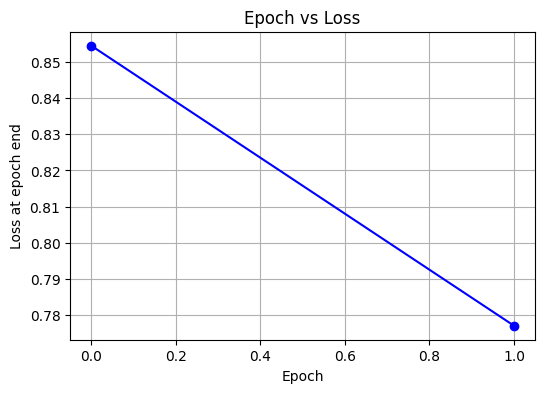

<class 'list'>


In [ ]:
image_size = 28**2
batch_size = 100
dataset_size = 60000
hidden_layers = 3
hidden_layer_size = 17
learning_rate = 0.5
epochs = 2
images_path = "MNIST/train-images.idx3-ubyte"
labels_path = "MNIST/train-labels.idx1-ubyte"

cfg = Config(input_layer_size=image_size,
              output_layer_size=10,
              hidden_layer_num= hidden_layers,
              hidden_layer_size = hidden_layer_size,
              
              learning_rate=learning_rate,
              dataset_size=dataset_size,
              batch_size=batch_size,
              epochs=epochs
              )

net, (x_epoch, y_loss) = train(images_path, labels_path, cfg=cfg)
timestamp, f_name = save_weights_biases(net)
run_id, results_f_name, plot_f_name = save_performance(x_epoch,y_loss, cfg=cfg, timestamp=timestamp)


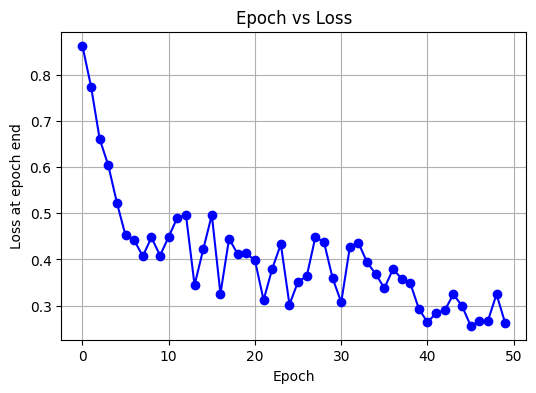

<class 'list'>


In [47]:
#for h_layers in range(1,4,1):
    #print("number of hidden layers: ", h_layers)

for lr in range(25, 1001, 50):
    print("learning rate: ", lr/1000)
    image_size = 28**2
    batch_size = 100
    dataset_size = 60000
    hidden_layers = 3
    hidden_layer_size = 15
    learning_rate = lr/1000
    epochs = 50
    images_path = "MNIST/train-images.idx3-ubyte"
    labels_path = "MNIST/train-labels.idx1-ubyte"

    cfg = Config(input_layer_size=image_size,
                output_layer_size=10,
                hidden_layer_num= hidden_layers,
                hidden_layer_size = hidden_layer_size,
                
                learning_rate=learning_rate,
                dataset_size=dataset_size,
                batch_size=batch_size,
                epochs=epochs
                )

    net, (x_epoch, y_loss) = train(images_path, labels_path, cfg=cfg)
    timestamp, f_name = save_weights_biases(net)
    run_id, results_f_name, plot_f_name = save_performance(x_epoch,y_loss, cfg=cfg, timestamp=timestamp)

In [ ]:
print(net.weights[0])

[[-0.80973079  0.31518904 -0.5694661  ...  0.34673816 -0.84530579
   0.76955888]
 [ 0.16239195 -0.76628202  0.89723473 ... -0.59568979  0.13230854
   0.4619788 ]
 [ 0.27108542  0.45940915  0.2584263  ... -0.98291468  0.02056311
  -0.31380448]
 ...
 [-0.54855168 -0.32313605 -0.96377876 ... -0.24690671  0.93215737
   0.49187448]
 [-0.02323715 -0.47469108  0.59625524 ... -0.58621319 -0.74342725
  -0.31139833]
 [-0.97844035 -0.01049598  0.71944829 ... -0.93374426 -0.88549989
  -0.5669228 ]]


In [1]:
f = open("MNIST/t10k-images.idx3-ubyte", 'rb')

image_size = 28
num_images = 50
choice = 15

try:
    f.read(16)
except UnicodeDecodeError as error:
    print(error)
    print("utf-8 error is usally due to binary format")


buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
batch = data.reshape(num_images, 28*28)
data = data.reshape(num_images, image_size, image_size, 1)

import matplotlib.pyplot as plt
image = np.asarray(data[choice]).squeeze()
plt.imshow(image)
plt.show()

l = open("MNIST/t10k-labels.idx1-ubyte",'rb')
l.read(8)
buf = l.read(10000)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print("image key: ", labels[choice])

inlayer = batch[choice]
net = forward(inlayer, net)
np.set_printoptions(precision=4, suppress=True)
print("network's guess: ", np.argmax(net.layers[-1]))

print(net.layers[-1])



NameError: name 'np' is not defined

In [7]:
import pickle

with open("n_net_with_weights.pkl", "wb") as f:
    pickle.dump(net, f)

    

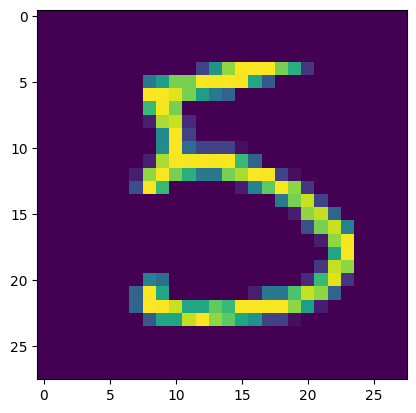

5
[0.0369 0.0004 0.0006 0.0978 0.0004 0.7629 0.0003 0.0027 0.0344 0.0008]
5


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_27556\4248139387.py:71: RuntimeWarning: overflow encountered in exp
  return( 1/(1+np.exp(-input)))


In [8]:
with open("n_net_with_weights.pkl", "rb") as f:
    net_loaded = pickle.load(f)

f = open("MNIST/t10k-images.idx3-ubyte", 'rb')

image_size = 28
num_images = 50
choice = 15

try:
    f.read(16)
except UnicodeDecodeError as error:
    print(error)
    print("utf-8 error is usally due to binary format")


buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
batch = data.reshape(num_images, 28*28)
data = data.reshape(num_images, image_size, image_size, 1)

import matplotlib.pyplot as plt
image = np.asarray(data[choice]).squeeze()
plt.imshow(image)
plt.show()

l = open("MNIST/t10k-labels.idx1-ubyte",'rb')
l.read(8)
buf = l.read(10000)
labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
print(labels[choice])

inlayer = batch[choice]
net_loaded = forward(inlayer, net_loaded)
np.set_printoptions(precision=4, suppress=True)
print(net_loaded.layers[-1])
print(np.argmax(net_loaded.layers[-1]))


In [ ]:
net = create_network(3,5,1,2)
input = [1,1,1]
output = [0,1,0,1,0]

net.weights[1] = np.transpose(np.array([[0,0],
                           [0.5,0.5],
                           [0.3,-1],
                           [0.3,-1],
                           [0.1,0.1]]))
net.weights[0] = (np.array([[1,1],
                           [0.5,0.5],
                           [0.3,-1]]))
print(np.shape(net.weights[1]))

net = forward(input,net)
w_delta, b_delta = backprop_single(net, output)


In [ ]:
net = create_network(3,5,2,2)
input = [1,1,1]
output = [0,1,0,0,0]

net = forward(input,net)
w_delta, b_delta = backprop_single(net, output)

for index in range(len(net.layers)):
    print("index position: ", index)

    print("layer size and shape: ", net.layers[index].shape)

    try:
        print("weights size and shape: ", net.weights[index].shape)
    except IndexError:
        pass
    try:
        print("bias size and shape: ", net.biases[index].shape)
    except IndexError:
        pass
    print("\n")

print(net.weights[-1])

